# Desarrollo proyecto Sistemas inteligentes
## Perfil de Consumidor

P2-PerfilCons
Integrantes: Michelle Soto Florido, Andrés Parra Rodríguez, Julio Alberto Parra Martínez, Carlos A. Talero Jacome

En este se describe el desarrollo del modelo de una red neuronal para identificar los posibles tipos de productos a comprar de un cliente en una página de internet. Esto se realizó con la base de datos Customer
Personality Analysis de la página de internet Kaggle.

### 1. Lectura base de datos

Se realiza lectura de la base de datos directamente del archivo descargado. Luego se eliminan variables que no contienen información (Z_CostContact y Z_Revenue) y las que no se emplearán para el modelo (ID y Complain)

In [33]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Lectura datos
data = pd.read_csv("Customer Personality Analysis.csv",sep='\t')
# Eliminacion de variables no usadas
data.drop(['ID','Z_CostContact', 'Z_Revenue','Dt_Customer','Complain'], axis=1, inplace=True)
# Eliminacion de datos NaN
data = data.dropna()
data.reset_index(drop=True, inplace=True)

### 2. Transformación de las salidas
El propósito de este modelo es predecir con datos demográficos y de comportamiento qué artículos es más probable que compren los usuarios de la plataforma. Las salidas del sistema es un conjunto de datos binarios, donde cada dígito indica la probabilidad de que el usuario puede comprar el artículo o no.

Para esto se hace una frontera con la mediana de cada variable.

Mediana de Wines = 174.5
Media de Wines = 305.09160649819495
Mediana de Fruits = 8.0
Media de Fruits = 26.356046931407942
Mediana de Meats = 68.0
Media de Meats = 166.99593862815885
Mediana de Fish = 12.0
Media de Fish = 37.63763537906137
Mediana de Sweets = 8.0
Media de Sweets = 27.028880866425993
Mediana de Gold = 24.5
Media de Gold = 43.96525270758123


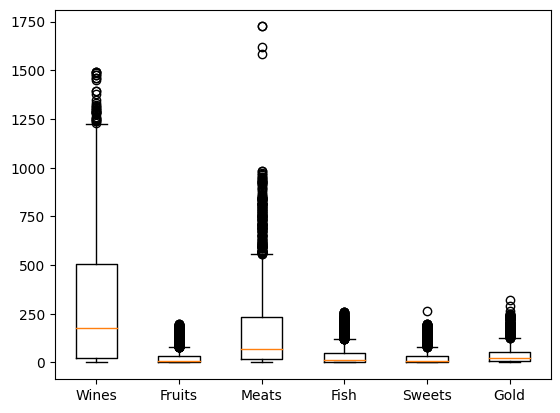

In [34]:
# Sustrae los targets
targets = data.loc[:, ["MntWines","MntFruits","MntMeatProducts","MntFishProducts","MntSweetProducts","MntGoldProds"]]
data.drop(["MntWines","MntFruits","MntMeatProducts","MntFishProducts","MntSweetProducts","MntGoldProds"], axis=1, inplace=True)

# Transformacion de la salidas (6) Escoge las menores de la mitad de los datos (menores a mediana) con Normalizacion (z-score)
scalert = StandardScaler()
labels = pd.DataFrame(scalert.fit_transform(targets))
for i in range(targets.shape[1]):
    labels[i] = targets.iloc[:,i] >= np.median(targets.iloc[:,i])
labels = labels.replace({False: 0, True: 1})

# Frontera de desición mediana para binarizar targets
tarNames = ['Wines','Fruits','Meats','Fish','Sweets','Gold']
for i in range(targets.shape[1]):
    print('Mediana de ' + tarNames[i] + ' = ' + str(np.median(targets.iloc[:,i])))
    print('Media de ' + tarNames[i] + ' = ' + str(np.mean(targets.iloc[:,i])))

# Boxplot de targets sin normalizar
plt.boxplot(targets,labels=tarNames);

3. Transformaciones a datos de entrada

Se toquenizó en número dos variables que venían como texto (Education y Marital_Status). Se generaron dos nuevas variables que dan información sobre el total de compras y el total de promociones acptadas por cada persona. Finalmente se realizó una estandarización con Z-Score

In [27]:
# Strings a numeros (Tokenizacion)
label_encoder = LabelEncoder()
data['Education'] = label_encoder.fit_transform(data.loc[:,['Education']])
data['Marital_Status'] = label_encoder.fit_transform(data.loc[:,['Marital_Status']])

# Transformacion logaritmica a datos sesgados a la derecha
# data[] = np.log(data['Income'], 10)

# Nuevas variables
# Total promociones aceptadas
data['Total promociones'] = data['AcceptedCmp3']+data['AcceptedCmp4']+data['AcceptedCmp5']+data['AcceptedCmp1']+data['AcceptedCmp2']+data['Response']
# Total compras realizadas
data['Total Compras'] = data['NumDealsPurchases']+data['NumWebPurchases']+data['NumCatalogPurchases']+data['NumStorePurchases']

# Normalizacion a todas (z-score)
scaler = StandardScaler()
data = scaler.fit_transform(data)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


4. Separación entre conjuntos de entrenamiento, test y validación.

Se separaron las observaciones en tres conjuntos de datos:
entrenamiento: 60%
test: 40%
validación 10%

In [28]:
# Separacion entre datos entrenamiento, prueba y validación.
seed = 50
# Division de conjuntos de entrenamiento (60%) y los otros
X_train, X_temp = train_test_split(data, test_size=0.4, random_state=seed)
# Divicion entre datos de validacion (10%) y test (30%)
X_test, X_vali = train_test_split(X_temp, test_size=0.25, random_state=seed)

# Division de conjuntos de entrenamiento (60%) y los otros
y_train, y_temp = train_test_split(labels, test_size=0.4, random_state=seed)
# Divicion entre datos de validacion (10%) y test (30%)
y_test, y_vali = train_test_split(y_temp, test_size=0.25, random_state=seed)


5. Entrenamiento del modelo

Se empleó una red neuronal clásica con dos capas ocultas, cada una con 128 neuronas. Como función de activación se empleó ReLU (Rectified Linear Unit).

In [29]:
# Red Neuronal con sus parametros
model = MLPClassifier(hidden_layer_sizes=(128, 128), activation='relu', max_iter=1000, random_state=42)

# Entrena el modelo
model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=1000, random_state=42)

6. Evaluación del modelo con datos de test

In [30]:
# Test del model
test_accuracy = model.score(X_test, y_test)
print(f'Precisión en datos de prueba: {test_accuracy}')

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

# Funcion m.confunsion
def confu(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    exactitud = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    especificidad = TN / (TN + FP)
    sensibilidad = TP / (TP + FN)
    print(confusion)
    print('Exactitud = ' + str(exactitud))
    print('Precision = ' + str(precision))
    print('Especificidad = ' + str(especificidad))
    print('Sensibilidad = ' + str(sensibilidad))


# Calcular la matrices de confusión
tarNames = ['Wines','Fruits','Meats','Fish','Sweets','Gold']
print('Predicciones con datos de test')
for i in range(targets.shape[1]):
    print(tarNames[i])
    confu(y_test.iloc[:,i], y_pred[:,i])
    print(' ')

Precisión en datos de prueba: 0.47218045112781953
Predicciones con datos de test
Wines
[[319  25]
 [ 19 302]]
Exactitud = 0.9338345864661655
Precision = 0.9235474006116208
Especificidad = 0.9273255813953488
Sensibilidad = 0.940809968847352
 
Fruits
[[259  68]
 [ 67 271]]
Exactitud = 0.7969924812030075
Precision = 0.799410029498525
Especificidad = 0.7920489296636085
Sensibilidad = 0.8017751479289941
 
Meats
[[313  31]
 [ 30 291]]
Exactitud = 0.9082706766917293
Precision = 0.9037267080745341
Especificidad = 0.9098837209302325
Sensibilidad = 0.9065420560747663
 
Fish
[[262  68]
 [ 63 272]]
Exactitud = 0.8030075187969925
Precision = 0.8
Especificidad = 0.793939393939394
Sensibilidad = 0.8119402985074626
 
Sweets
[[250  71]
 [ 65 279]]
Exactitud = 0.7954887218045112
Precision = 0.7971428571428572
Especificidad = 0.778816199376947
Sensibilidad = 0.811046511627907
 
Gold
[[260  63]
 [ 83 259]]
Exactitud = 0.7804511278195488
Precision = 0.8043478260869565
Especificidad = 0.804953560371517
Sens

7. Evaluación del modelo con datos de validación

In [31]:
# Predicciones en el conjunto de validación
y_pred2 = model.predict(X_vali)

# Calcular la matrices de confusión
tarNames = ['Wines','Fruits','Meats','Fish','Sweets','Gold']
print('Predicciones con datos de validacion')
for i in range(targets.shape[1]):
    print(tarNames[i])
    confu(y_vali.iloc[:,i], y_pred2[:,i])
    print(' ')

Predicciones con datos de validacion
Wines
[[ 95  14]
 [  7 106]]
Exactitud = 0.9054054054054054
Precision = 0.8833333333333333
Especificidad = 0.8715596330275229
Sensibilidad = 0.9380530973451328
 
Fruits
[[84 24]
 [16 98]]
Exactitud = 0.8198198198198198
Precision = 0.8032786885245902
Especificidad = 0.7777777777777778
Sensibilidad = 0.8596491228070176
 
Meats
[[ 94   6]
 [  8 114]]
Exactitud = 0.9369369369369369
Precision = 0.95
Especificidad = 0.94
Sensibilidad = 0.9344262295081968
 
Fish
[[81 28]
 [23 90]]
Exactitud = 0.7702702702702703
Precision = 0.7627118644067796
Especificidad = 0.7431192660550459
Sensibilidad = 0.7964601769911505
 
Sweets
[[79 22]
 [27 94]]
Exactitud = 0.7792792792792793
Precision = 0.8103448275862069
Especificidad = 0.7821782178217822
Sensibilidad = 0.7768595041322314
 
Gold
[[86 27]
 [24 85]]
Exactitud = 0.7702702702702703
Precision = 0.7589285714285714
Especificidad = 0.7610619469026548
Sensibilidad = 0.7798165137614679
 
